In [1]:
import subprocess
import geojson
import firedrake
import icepack
import numpy as np
import math
import rasterio
import icepack.plot
from firedrake import assemble, Constant, inner, grad, dx, sym, sqrt, tr, ds
import matplotlib.pyplot as plt
import pickle
from icepack.statistics import (
    StatisticsProblem,
    MaximumProbabilityEstimator,
)
from rasterio.plot import show
import geojson
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import pandas as pd
from rasterio.crs import CRS
from rasterio.transform import from_origin
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


### Load extraction locations

In [2]:
with open("/home/sermilik/brunt_model/output_extraction_locations.pkl", "rb") as f1:
    extraction_locations = pickle.load(f1)

f1.close()

#perpendicular angles
west_angle = extraction_locations["west_angle"]
east_angle = extraction_locations["east_angle"]
#extraction points
w_n_x_calv = extraction_locations["w_n_x_calv"]
w_n_y_calv = extraction_locations["w_n_y_calv"]
w_s_x_calv = extraction_locations["w_s_x_calv"]
w_s_y_calv = extraction_locations["w_s_y_calv"]
e_n_x_calv = extraction_locations["e_n_x_calv"]
e_n_y_calv = extraction_locations["e_n_y_calv"]
e_s_x_calv = extraction_locations["e_s_x_calv"]
e_s_y_calv = extraction_locations["e_s_y_calv"]


with open("/home/sermilik/brunt_model/output_for_plotting.pkl", "rb") as f2:
    for_plotting = pickle.load(f2)
    
f2.close()

xmin = for_plotting["xmin"]
xmax = for_plotting["xmax"]
ymin = for_plotting["ymin"]
ymax = for_plotting["ymax"]
xmin_ew = for_plotting["xmin_ew"]
xmax_ew = for_plotting["xmax_ew"]
ymin_ew = for_plotting["ymin_ew"]
ymax_ew = for_plotting["ymax_ew"]
xcen_w = for_plotting["xcen_w"]
ycen_w = for_plotting["ycen_w"]
xcen_e = for_plotting["xcen_e"]
ycen_e = for_plotting["ycen_e"]
delta = for_plotting["delta"]
easting_w_n = for_plotting["easting_w_n"]
northing_w_n = for_plotting["northing_w_n"]
easting_w_s = for_plotting["easting_w_s"]
northing_w_s = for_plotting["northing_w_s"]
easting_e_n = for_plotting["easting_e_n"]
northing_e_n = for_plotting["northing_e_n"]
easting_e_s = for_plotting["easting_e_s"]
northing_e_s = for_plotting["northing_e_s"]

extent = (xmin, xmax, ymin, ymax)


### Geometry

In [3]:
outline_2021 = '/home/sermilik/brunt_model/d02_calving/brunt_HC_2021_calving.geojson'
#Brunt_SWIT_HC_2020_cutoff_r.geojson'
#brunt_HC_2020.geojson'

with open(outline_2021,"r") as outline_file_2021:
    outline_2021 = geojson.load(outline_file_2021)
    
print(outline_2021["crs"]["properties"]["name"])

urn:ogc:def:crs:EPSG::3031


### Imagery

In [4]:
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
image_file = rasterio.open(image_filename, "r")

transform = image_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax, transform=transform
)

image = image_file.read(indexes=1, window=window, masked=True)

### meshing

In [5]:
geometry_2021 = icepack.meshing.collection_to_geo(outline_2021)

with open("brunt_2021.geo", "w") as geo_file_2021:
    geo_file_2021.write(geometry_2021.get_code())
    
!gmsh -2 -format msh2 -v 2 -o brunt_2021.msh brunt_2021.geo

mesh_2021 = firedrake.Mesh("brunt_2021.msh")

### Input data - thickness

In [6]:
thickness_filename = '/home/sermilik/brunt_model/thickness_brunt_fullcalc.tif'
thickness = rasterio.open(thickness_filename,"r")

Q_2021 = firedrake.FunctionSpace(mesh_2021, "CG", 2)
h0_2021 = icepack.interpolate(thickness, Q_2021)

In [7]:
#smooth the DEM

h_2021 = h0_2021.copy(deepcopy=True)
α = firedrake.Constant(2e3)
J_2021 = 0.5 * (h_2021 - h0_2021)**2 * dx + 0.5 * α**2 * inner(grad(h_2021), grad(h_2021)) * dx
F_2021 = firedrake.derivative(J_2021, h_2021)
firedrake.solve(F_2021 == 0, h_2021)

### Input data - velocity/velocity error

In [8]:
# SNAP velocity
velocity_filename_vx_2021 = '/home/sermilik/brunt_model/d02_calving/Velocity_ps_20210318_20210330_vx_filt15.tif'
velocity_filename_vy_2021 = '/home/sermilik/brunt_model/d02_calving/Velocity_ps_20210318_20210330_vy_filt15.tif'

vx_2021 = rasterio.open(velocity_filename_vx_2021, "r")
vy_2021 = rasterio.open(velocity_filename_vy_2021, "r")

V_2021 = firedrake.VectorFunctionSpace(mesh_2021, "CG", 2)
u0_2021 = icepack.interpolate((vx_2021,vy_2021), V_2021)

In [9]:
velocity_filename_vx_2021_err = '/home/sermilik/brunt_model/Velocity_ps_error_5_0.tif'
velocity_filename_vy_2021_err = '/home/sermilik/brunt_model/Velocity_ps_error_5_0.tif'

stdx_2021 = rasterio.open(velocity_filename_vx_2021_err, "r")
stdy_2021 = rasterio.open(velocity_filename_vy_2021_err, "r")

σx_2021 = icepack.interpolate(stdx_2021, Q_2021)
σy_2021 = icepack.interpolate(stdy_2021, Q_2021)

### plot inputs

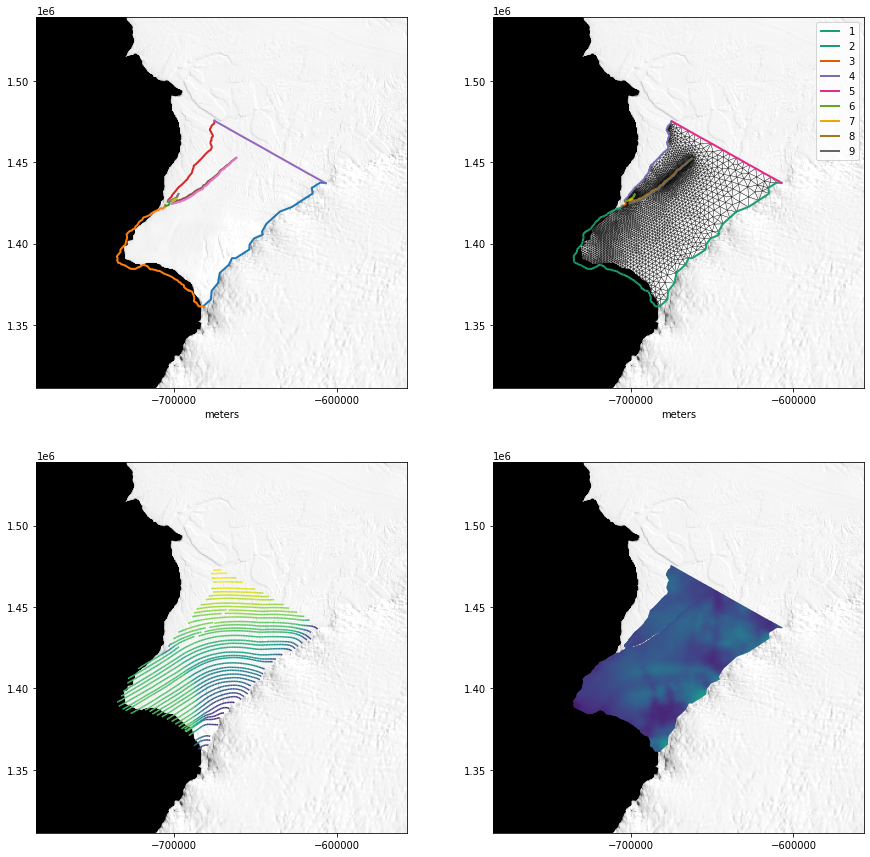

In [10]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

#OUTLINE
axes[0,0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[0,0].plot(xs[:, 0], xs[:, 1], linewidth=2)
axes[0,0].locator_params(axis='x',nbins=4)
axes[0,0].set_xlabel("meters");

#MESH
axes[0,1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[0,1].set_xlabel("meters")
kwargs = {
    "interior_kw": {"linewidth": 0.25},
    "boundary_kw": {"linewidth": 2},
}
icepack.plot.triplot(mesh_2021, axes=axes[0,1], **kwargs)
axes[0,1].locator_params(axis='x',nbins=4)
axes[0,1].legend();

#VELOCITY STREAMLINE
axes[1,0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
streamlines = icepack.plot.streamplot(
    u0_2021, precision=1000, density=2000, axes=axes[1,0]
)
axes[1,0].locator_params(axis='x',nbins=4)
#fig.colorbar(streamlines, label="meters/year");

#THICKNESS RASTER
axes[1,1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(h_2021, vmin=0, vmax=500, axes=axes[1,1])
axes[1,1].locator_params(axis='x',nbins=4)
#fig.colorbar(colors, label="thickness");

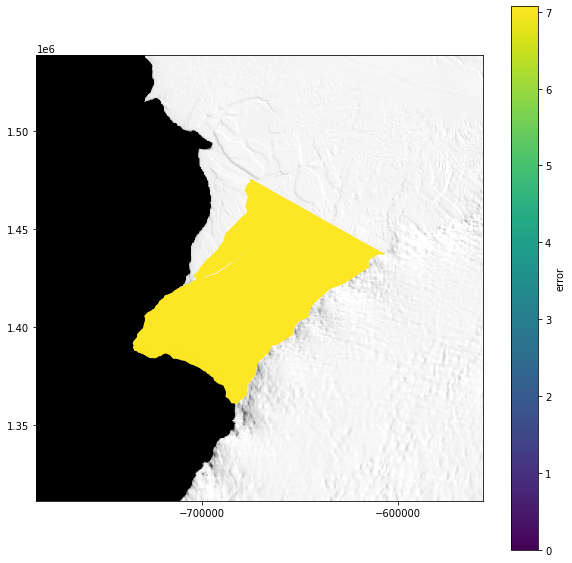

In [11]:
σ_2021 = firedrake.interpolate(firedrake.sqrt(σx_2021**2 + σy_2021**2), Q_2021)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(σ_2021, vmin=0, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors, label="error");

In [12]:
T = Constant(253)
A0 = icepack.rate_factor(T)


def viscosity(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    θ = kwargs["log_fluidity"]

    A = A0 * firedrake.exp(θ)
    return icepack.models.viscosity.viscosity_depth_averaged(
        velocity=u, thickness=h, fluidity=A
    )


model = icepack.models.IceShelf(viscosity=viscosity)
opts = {
    "dirichlet_ids": [1, 3, 5],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)

θ = firedrake.Function(Q_2021)
u = solver.diagnostic_solve(
    velocity=u0_2021,
    thickness=h_2021,
    log_fluidity=θ,
)

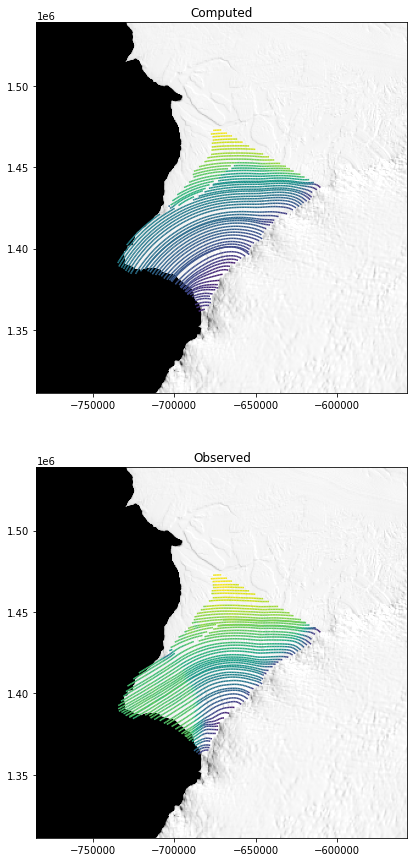

In [13]:
fig, axes = plt.subplots(2,1, figsize=(7.5,15))
kwargs = {"precision": 1000, "density": 1500}
axes[0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
axes[0].set_title("Computed")
axes[1].set_title("Observed")
icepack.plot.streamplot(u, axes=axes[0], **kwargs)
icepack.plot.streamplot(u0_2021, axes=axes[1], **kwargs);


### Inferring the fluidity

There are four parts that go into an inverse problem:

* a physics model
* an initial guess for the parameter and state
* an error metric
* a smoothness metric

We already have the physics model and some initial guesses.
The physics are wrapped up in the Python function `simulation` defined below; we'll pass this function when we create the inverse problem.

In [14]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u0_2021,
        thickness=h_2021,
        log_fluidity=θ,
    )

In [15]:
area = Constant(assemble(Constant(1.0) * dx(mesh_2021)))

In [16]:
def loss_functional(u):
    δu = u - u0_2021
    return 0.5 / area * ((δu[0] / σx_2021)**2 + (δu[1] / σy_2021)**2) * dx


def regularization(θ):
    Θ = Constant(1.)
    L = Constant(7.5e3)
    return 0.5 / area * (L / Θ)**2 * inner(grad(θ), grad(θ)) * dx

In [17]:
problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=θ,
)

In [18]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-2, 
    max_iterations=500,
)
θ = estimator.solve()



Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     1.907992e+03   4.234230e-02                  4.234230e-02   
  1     1.907990e+03   4.234233e-02   4.234230e-02   1.058558e-01   3         2         0         1         2         
  2     1.907985e+03   4.234239e-02   1.058558e-01   2.646394e-01   4         3         0         1         2         
  3     1.907974e+03   4.234255e-02   2.646394e-01   6.615985e-01   5         4         0         1         2         
  4     1.907946e+03   4.234296e-02   6.615985e-01   1.653996e+00   6         5         0         1         2         
  5     1.907876e+03   4.234397e-02   1.653996e+00   4.134991e+00   7         6         0         1         2         
  6     1.907701e+03   4.234652e-02   4.134991e+00   1.033748e+01   8         7         0         1         2         
  7     1.907263e+03   4.235309e-02   1.033748e+01   2.584369e+0

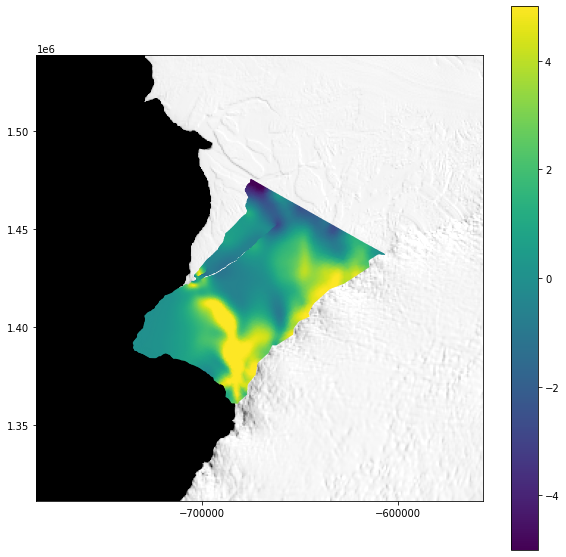

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(θ, vmin=-5, vmax=+5, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

In [20]:
u_2021 = simulation(θ)

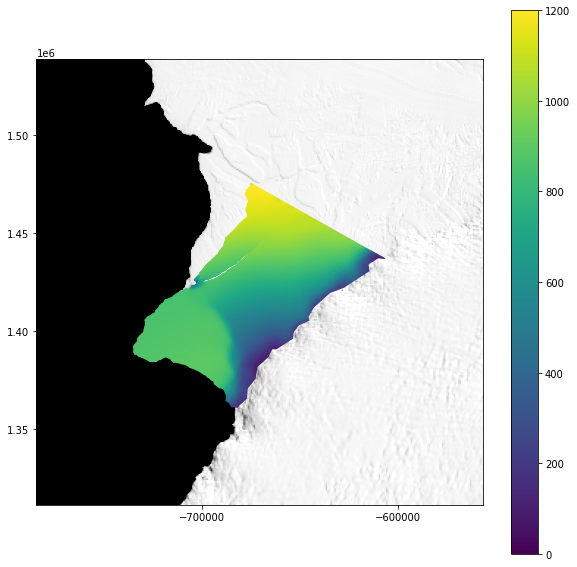

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

In [22]:
visc_temp = viscosity(velocity=u_2021,thickness=h_2021,log_fluidity=θ)
visc = firedrake.project(visc_temp, Q_2021)

fluidA = A0 * firedrake.exp(θ)
fluidityA = firedrake.project(fluidA, Q_2021)

TFS_2021 = firedrake.TensorFunctionSpace(mesh_2021, "DG", 1)
ε = firedrake.project(sym(grad(u_2021)), TFS_2021)
#ε_e = firedrake.project(1e3 * sqrt(inner(ε, ε) + tr(ε) ** 2), Q_2021)

In [23]:
exx = firedrake.project(ε[0,0], Q_2021)
exy = firedrake.project(ε[0,1], Q_2021)
eyx = firedrake.project(ε[1,0], Q_2021)
eyy = firedrake.project(ε[1,1], Q_2021)


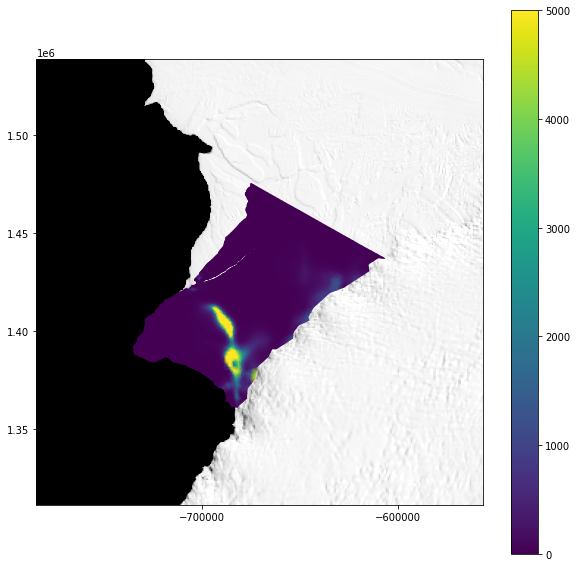

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = firedrake.tripcolor(fluidityA, vmin=0, vmax=5000, axes=ax)  
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

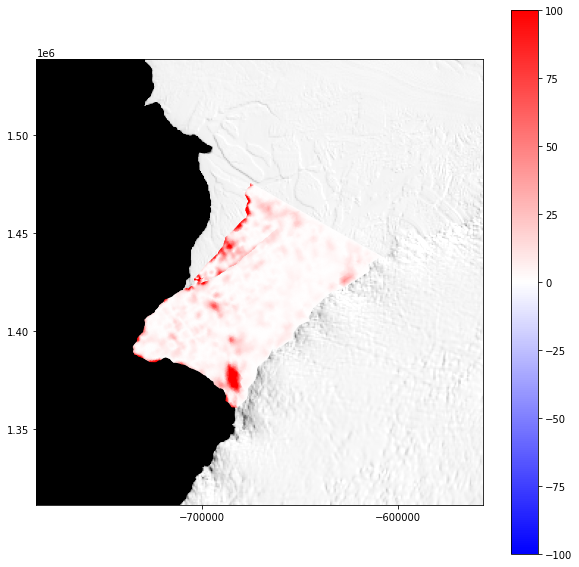

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
δu = firedrake.interpolate((u_2021 - u0_2021)**2 / (2 * σ_2021**2), Q_2021)
#δu = firedrake.interpolate((u_2021 - u0_2021) / u0_2021, Q_2021)
colors = icepack.plot.tripcolor(δu, vmin=-100, vmax=100, cmap="bwr", axes=ax)
ax.locator_params(axis='x',nbins=4)
fig.colorbar(colors);

### Grounding line flux

In [26]:
ν = firedrake.FacetNormal(mesh_2021)
influx_gl = -h_2021 * inner(u_2021, ν) * ds(1)
influx_sw = -h_2021 * inner(u_2021, ν) * ds(5)

influx_FT_gl = -h_2021 * inner(u0_2021, ν) * ds(1)
influx_FT_sw = -h_2021 * inner(u0_2021, ν) * ds(5)

print(f"Influx (grounding line): {firedrake.assemble(influx_gl) / 1e9} km^3 / year")
print(f"Influx (Stancomb-Wills): {firedrake.assemble(influx_sw) / 1e9} km^3 / year")
print("----------")
print("from FT (noisy)")
print(f"Influx FT (grounding line): {firedrake.assemble(influx_FT_gl) / 1e9} km^3 / year")
print(f"Influx FT (Stancomb-Wills): {firedrake.assemble(influx_FT_sw) / 1e9} km^3 / year")

Influx (grounding line): 3.308963377710457 km^3 / year
Influx (Stancomb-Wills): 3.8556659263151936 km^3 / year
----------
from FT (noisy)
Influx FT (grounding line): 3.308963377710457 km^3 / year
Influx FT (Stancomb-Wills): 3.8556659263151936 km^3 / year


### Make tif

In [27]:
shelf_outline = [
( -606837.6, 1437110.4 ), ( -610183.2, 1437503.2 ), ( -615426.3, 1434163.1 ), ( -614941.4, 1430772.5 ), ( -627707.1, 1422470.6 ), ( -634967.3, 1419676.9 ), ( -643370.1, 1412098.9 ), ( -646085.9, 1407167.4 ), ( -645495.2, 1405566.9 ), ( -650852.7, 1403200.7 ), ( -653614.5, 1399491.6 ), ( -653840.4, 1396359.7 ), ( -662256.4, 1391003.6 ), ( -664387.2, 1391078.8 ), ( -666392.8, 1386979.7 ), ( -671966.0, 1381936.3 ), ( -673018.5, 1375798.3 ), ( -676963.7, 1370930.0 ), ( -677400.2, 1365695.3 ), ( -681830.9, 1361740.6 ), ( -681770.4, 1361316.1 ), 
( -681770.4, 1361316.1 ), ( -684916.3, 1361504.0 ), ( -686289.7, 1363718.0 ), ( -687825.9, 1364577.8 ), ( -687556.8, 1367068.9 ), ( -688120.4, 1368564.4 ), ( -688965.7, 1370428.5 ), ( -690656.4, 1371295.5 ), ( -690959.9, 1371013.8 ), ( -693777.7, 1373125.9 ), ( -694019.7, 1374484.2 ), ( -695458.8, 1375210.5 ), ( -696238.9, 1376152.0 ), ( -697208.2, 1376586.4 ), ( -697891.0, 1377458.8 ), ( -699218.6, 1378027.8 ), ( -701532.5, 1379658.9 ), ( -704415.3, 1380910.7 ), ( -706273.9, 1381593.4 ), ( -707563.6, 1382465.9 ), ( -708853.3, 1383186.6 ), ( -710552.5, 1383365.5 ), ( -711369.2, 1383829.0 ), ( -712207.9, 1383917.3 ), ( -713333.5, 1384226.3 ), ( -714547.5, 1384204.2 ), ( -715629.0, 1385197.4 ), ( -716247.0, 1386058.2 ), ( -717725.7, 1386610.0 ), ( -718365.8, 1386985.2 ), ( -719491.5, 1386720.3 ), ( -720595.0, 1386080.3 ), ( -721367.5, 1385418.1 ), ( -721963.5, 1385550.6 ), ( -723657.3, 1384464.6 ), ( -725302.8, 1384486.0 ), ( -726670.5, 1384550.1 ), ( -728252.0, 1385469.0 ), ( -728978.6, 1385917.8 ), ( -729747.9, 1386323.9 ), ( -730047.1, 1386665.8 ), ( -730698.1, 1386730.0 ), ( -731720.9, 1387145.5 ), ( -732360.1, 1387305.4 ), ( -733265.7, 1388093.7 ), ( -734360.2, 1388243.5 ), ( -734616.8, 1389059.7 ), ( -734966.6, 1389526.1 ), ( -734640.1, 1390832.0 ), ( -735176.4, 1391974.7 ), ( -734500.2, 1393024.1 ), ( -732961.0, 1394819.7 ), ( -732891.1, 1396382.1 ), ( -731678.4, 1397734.7 ), ( -729853.9, 1399522.8 ), ( -729505.7, 1401394.2 ), ( -728939.9, 1403178.6 ), ( -728896.4, 1404506.0 ), ( -729201.0, 1405768.1 ), ( -727503.7, 1407508.9 ), ( -726045.8, 1408052.9 ), ( -725110.1, 1408901.6 ), ( -724587.8, 1409010.4 ), ( -724000.3, 1409467.4 ), ( -723652.1, 1410555.4 ), ( -722576.3, 1411485.1 ), ( -722007.7, 1412246.6 ), ( -721652.3, 1413160.4 ), ( -719540.5, 1414744.3 ), ( -718911.0, 1416003.3 ), ( -717348.2, 1416474.4 ), ( -715711.4, 1417194.6 ), ( -714387.5, 1417812.9 ), ( -714409.3, 1418249.4 ), ( -712453.2, 1419464.6 ), ( -710128.5, 1420521.2 ), ( -709608.3, 1420521.2 ), ( -709283.2, 1420862.6 ), ( -709283.2, 1421155.2 ), ( -708145.2, 1421724.2 ), ( -707007.3, 1421415.4 ), ( -705934.3, 1422439.5 ), ( -705381.6, 1422715.9 ), ( -705089.0, 1422911.0 ), ( -705237.7, 1423407.6 ),
( -705237.7, 1423407.6 ), ( -704866.5, 1423373.0 ), ( -704464.1, 1423373.4 ), ( -704260.1, 1423364.9 ), ( -703979.6, 1423398.9 ), ( -703682.0, 1423517.9 ), ( -703446.2, 1423675.2 ), ( -703240.0, 1423823.9 ), ( -703078.5, 1424002.5 ), ( -702877.0, 1424290.1 ), ( -702763.9, 1424606.0 ), ( -702755.4, 1424988.6 ), ( -702823.4, 1425252.1 ), ( -703293.3, 1425747.4 ), ( -703703.6, 1425904.1 ), ( -703786.6, 1425906.7 ),
( -703786.6, 1425906.7 ), ( -703799.3, 1426423.3 ), ( -703534.4, 1426843.6 ), ( -702860.9, 1427488.4 ), ( -702112.5, 1428317.4 ), ( -701467.7, 1428812.5 ), ( -701370.0, 1429155.3 ), ( -701419.6, 1429388.8 ), ( -700952.4, 1430061.2 ), ( -700308.4, 1430853.9 ), ( -699310.4, 1432000.5 ), ( -698921.1, 1432453.5 ), ( -698441.4, 1433079.6 ), ( -697903.6, 1433818.3 ), ( -697197.5, 1434611.3 ), ( -696263.3, 1435328.3 ), ( -694035.6, 1437357.1 ), ( -692830.4, 1438648.8 ), ( -691717.5, 1439588.7 ), ( -691631.0, 1440194.2 ), ( -690290.4, 1441947.7 ), ( -689061.2, 1443460.0 ), ( -688416.7, 1445980.1 ), ( -688089.6, 1446353.9 ), ( -687902.7, 1447825.7 ), ( -686337.5, 1449063.9 ), ( -684445.1, 1450932.8 ), ( -682482.7, 1452942.0 ), ( -680753.9, 1454951.1 ), ( -678985.3, 1456627.5 ), ( -677382.0, 1457736.7 ), ( -676766.9, 1459360.2 ), ( -677694.5, 1461678.0 ), ( -677532.1, 1462951.6 ), ( -676972.8, 1463422.6 ), ( -677078.8, 1463958.3 ), ( -676832.8, 1465264.8 ), ( -676166.9, 1465818.2 ), ( -676223.1, 1466606.1 ), ( -676889.1, 1467562.9 ), ( -677433.2, 1468894.9 ), ( -677855.3, 1469298.2 ), ( -678018.0, 1470026.3 ), ( -677864.9, 1470609.9 ), ( -677463.1, 1471040.5 ), ( -677223.9, 1471872.8 ), ( -676659.5, 1472743.5 ), ( -676037.6, 1473260.1 ), ( -675597.5, 1473422.8 ), ( -675227.1, 1474310.8 ), ( -675195.6, 1475472.8 ),
( -675195.6, 1475472.8 ), ( -672193.0, 1473752.1 ), ( -668783.9, 1471832.9 ), ( -664541.5, 1469408.7 ), ( -661006.2, 1467413.8 ), ( -657285.9, 1465304.9 ), ( -650488.9, 1461569.7 ), ( -643122.6, 1457399.5 ), ( -639355.2, 1455235.3 ), ( -635026.7, 1452830.6 ), ( -630618.1, 1450345.7 ), ( -627091.2, 1448341.8 ), ( -623163.5, 1446177.6 ), ( -618434.2, 1443452.2 ), ( -613705.0, 1440887.2 ), ( -608237.9, 1437866.1 ), ( -606837.6, 1437110.4 ) 
]

shelf_poly = Polygon(shelf_outline)


rift_outline = [
( -701241.6, 1424581.4 ), ( -700522.0, 1424890.9 ), ( -700359.5, 1424898.6 ), ( -699547.1, 1425455.7 ), ( -698773.3, 1425958.6 ), ( -697922.2, 1426631.8 ), ( -697264.6, 1426422.9 ), ( -696912.0, 1426540.3 ), ( -696362.0, 1426882.0 ), ( -696312.0, 1426740.3 ), ( -695495.5, 1427098.6 ), ( -694703.9, 1427515.3 ), ( -693737.3, 1428006.9 ), ( -693595.6, 1427873.6 ), ( -693012.3, 1428173.5 ), ( -691804.1, 1428923.5 ), ( -691020.9, 1429390.1 ), ( -691007.9, 1429534.2 ), ( -690775.5, 1429759.4 ), ( -690034.7, 1430158.8 ), ( -689199.6, 1430485.6 ), ( -688335.4, 1431044.8 ), ( -688110.2, 1431248.1 ), ( -687347.7, 1432010.7 ), ( -685829.3, 1432951.6 ), ( -685298.7, 1433225.0 ), ( -684237.6, 1433707.3 ), ( -684004.4, 1433739.5 ), ( -683401.5, 1434141.4 ), ( -682862.9, 1434326.3 ), ( -682388.5, 1434800.6 ), ( -682227.8, 1435564.4 ), ( -681841.9, 1435869.9 ), ( -681480.1, 1435990.4 ), ( -681118.4, 1435918.1 ), ( -680805.9, 1436065.7 ), ( -680568.1, 1436472.3 ), ( -679862.2, 1437070.7 ), ( -679939.0, 1437285.6 ), ( -679325.2, 1437822.6 ), ( -679355.9, 1438022.1 ), ( -679118.0, 1438306.0 ), ( -678143.7, 1438666.6 ), ( -678020.9, 1438988.8 ), ( -677691.0, 1439295.7 ), ( -677422.5, 1439364.8 ), ( -676747.3, 1439725.3 ), ( -676556.1, 1439888.2 ), ( -676458.9, 1440163.5 ), ( -676191.6, 1440357.9 ), ( -675730.0, 1440576.6 ), ( -675422.3, 1440835.7 ), ( -675033.6, 1440957.2 ), ( -674985.0, 1441256.8 ), ( -674588.1, 1441678.0 ), ( -673608.2, 1442228.7 ), ( -673600.1, 1442414.9 ), ( -672620.2, 1443354.3 ), ( -672425.3, 1443706.7 ), ( -672200.3, 1443915.6 ), ( -672079.8, 1444534.3 ), ( -671067.3, 1445378.0 ), ( -670432.6, 1445795.8 ), ( -669926.3, 1446036.9 ), ( -669653.1, 1446085.1 ), ( -668680.9, 1447089.5 ), ( -667786.0, 1447982.6 ), ( -667435.4, 1448127.4 ), ( -666924.8, 1448226.5 ), ( -666650.4, 1448584.7 ), ( -666299.8, 1449019.1 ), ( -665560.4, 1449567.9 ), ( -664661.1, 1450596.9 ), ( -664213.7, 1450949.0 ), ( -663669.9, 1451259.3 ), ( -663424.7, 1451442.5 ), ( -663022.8, 1451832.6 ), ( -662426.9, 1452277.2 ), ( -662214.8, 1452400.9 ), ( -662038.1, 1452582.0 ), ( -661808.4, 1452705.7 ),
( -661808.4, 1452705.7 ), ( -662197.2, 1452259.5 ), ( -663018.9, 1451610.1 ), ( -663385.5, 1451243.4 ), ( -663681.5, 1451013.7 ), ( -664120.1, 1450764.4 ), ( -664384.1, 1450530.0 ), ( -664539.5, 1450416.5 ), ( -664838.0, 1450014.3 ), ( -665065.3, 1449794.7 ), ( -665216.6, 1449510.5 ), ( -666168.9, 1448776.0 ), ( -666461.1, 1448330.0 ), ( -666601.7, 1448245.0 ), ( -666922.0, 1447865.8 ), ( -667242.4, 1447800.4 ), ( -667477.8, 1447735.0 ), ( -667844.4, 1447446.5 ), ( -668146.1, 1447171.4 ), ( -668234.8, 1446931.9 ), ( -668651.8, 1446647.9 ), ( -668926.9, 1446275.2 ), ( -669210.9, 1446009.0 ), ( -669210.9, 1445893.7 ), ( -669840.9, 1445467.7 ), ( -670249.1, 1445396.8 ), ( -670861.3, 1445015.2 ), ( -671362.3, 1444478.2 ), ( -671549.0, 1444378.2 ), ( -671562.3, 1444144.7 ), ( -671922.5, 1443811.3 ), ( -672122.6, 1443217.7 ), ( -672596.1, 1442630.8 ), ( -672936.2, 1442337.3 ), ( -672962.9, 1442184.0 ), ( -673496.5, 1441610.4 ), ( -674125.6, 1441305.1 ), ( -674505.2, 1440999.2 ), ( -674536.8, 1440767.2 ), ( -674879.6, 1440361.2 ), ( -675153.8, 1440287.4 ), ( -675486.0, 1439986.8 ), ( -676087.1, 1439681.0 ), ( -676276.9, 1439443.7 ), ( -676377.1, 1439143.2 ), ( -676983.3, 1438851.9 ), ( -677155.3, 1438697.5 ), ( -677441.9, 1438618.1 ), ( -677940.3, 1437965.4 ), ( -678341.7, 1437709.6 ), ( -678540.7, 1437572.8 ), ( -678613.6, 1437330.8 ), ( -678998.8, 1437080.9 ), ( -679152.4, 1436604.6 ), ( -679506.8, 1436388.4 ), ( -680440.1, 1435664.5 ), ( -680527.3, 1435472.6 ), ( -680963.5, 1435219.6 ), ( -681425.7, 1435141.1 ), ( -681661.2, 1434992.9 ), ( -682097.3, 1433954.9 ), ( -682566.8, 1433548.3 ), ( -683613.4, 1432969.7 ), ( -684549.3, 1432637.9 ), ( -685008.8, 1432280.5 ), ( -686948.7, 1431106.3 ), ( -687357.1, 1430680.9 ), ( -687306.1, 1430544.8 ), ( -688912.9, 1429446.3 ), ( -689588.0, 1429240.1 ), ( -690113.0, 1428696.3 ), ( -691744.4, 1427758.7 ), ( -694275.8, 1426408.6 ), ( -694800.8, 1426427.4 ), ( -696432.2, 1425639.8 ), ( -696638.4, 1425752.3 ), ( -698963.6, 1424946.0 ), ( -699207.4, 1425002.3 ), ( -700651.2, 1424608.5 ), ( -701241.6, 1424581.4 )
]

rift_poly = Polygon(rift_outline)


rift2_outline = [
( -703318.4, 1426137.2 ), ( -702904.9, 1426325.2 ), ( -702591.7, 1426187.4 ), ( -702053.0, 1426193.6 ), ( -701890.1, 1426193.6 ), ( -701658.3, 1426137.2 ), ( -701482.9, 1426199.9 ), ( -700956.7, 1426569.5 ), ( -700656.0, 1426857.6 ), ( -700432.6, 1427155.2 ), ( -699657.6, 1427552.6 ), ( -698928.4, 1427881.5 ), ( -698605.3, 1428127.4 ), ( -698450.8, 1428304.7 ), ( -697904.4, 1429351.3 ), ( -697741.2, 1429567.2 ), ( -697434.1, 1430219.8 ), ( -697151.0, 1430666.0 ), ( -697170.2, 1430666.0 ), ( -697434.1, 1430306.2 ), ( -697798.8, 1429591.2 ), ( -697928.4, 1429428.1 ), ( -698384.2, 1428569.2 ), ( -698528.1, 1428290.9 ), ( -698694.0, 1428133.6 ), ( -698984.8, 1427936.0 ), ( -699592.6, 1427678.7 ), ( -700237.5, 1427395.4 ), ( -700684.9, 1427212.7 ), ( -700923.5, 1427126.9 ), ( -701079.9, 1426984.1 ), ( -701089.5, 1426878.8 ), ( -701946.5, 1426510.2 ), ( -702228.9, 1426519.8 ), ( -702516.2, 1426404.9 ), ( -702712.5, 1426467.1 ), ( -702942.3, 1426481.5 ), ( -703339.6, 1426280.4 ), ( -703425.8, 1426160.7 ), ( -703334.9, 1426134.4 ), ( -703318.4, 1426137.2 )
]

rift2_poly = Polygon(rift2_outline)


rift3_outline = [
( -700861.7, 1426201.3 ), ( -700167.8, 1426558.8 ), ( -700079.9, 1426574.0 ), ( -699937.5, 1426698.2 ), ( -699616.4, 1426934.5 ), ( -699095.2, 1427216.3 ), ( -698886.2, 1427337.5 ), ( -698601.3, 1427552.6 ), ( -698904.3, 1427386.0 ), ( -699128.5, 1427267.8 ), ( -699322.5, 1427216.3 ), ( -699667.9, 1427061.8 ), ( -699931.5, 1426919.4 ), ( -700246.6, 1426737.6 ), ( -700379.9, 1426595.2 ), ( -700543.5, 1426464.9 ), ( -700646.5, 1426413.4 ), ( -700861.7, 1426216.4 ), ( -700861.7, 1426201.3 )
]

rift3_poly = Polygon(rift3_outline)


In [28]:
tifxmin = -750000
tifxmax = -600000
tifymin = 1350000
tifymax = 1500000
tifres = 100 #250

tifxlen = (tifxmax-tifxmin)/tifres
tifylen = (tifymax-tifymin)/tifres

tifx = np.linspace(tifxmin+(tifres/2),tifxmax-(tifres/2),num=int(tifxlen))
tify = np.linspace(tifymax-(tifres/2),tifymin+(tifres/2),num=int(tifylen))


In [29]:
tras = np.zeros((int(tifxlen),int(tifylen)))
vras = np.zeros((int(tifxlen),int(tifylen)))
vxras = np.zeros((int(tifxlen),int(tifylen)))
vyras = np.zeros((int(tifxlen),int(tifylen)))
viscos = np.zeros((int(tifxlen),int(tifylen)))
fluid = np.zeros((int(tifxlen),int(tifylen)))
#e_eff = np.zeros((int(tifxlen),int(tifylen)))
exxras = np.zeros((int(tifxlen),int(tifylen)))
exyras = np.zeros((int(tifxlen),int(tifylen)))
eyxras = np.zeros((int(tifxlen),int(tifylen)))
eyyras = np.zeros((int(tifxlen),int(tifylen)))

for tx in range(0,int(tifxlen)):
    for ty in range(0,int(tifylen)):
        on_shelf = shelf_poly.contains(Point(tifx[tx],tify[ty]))
        in_rift = rift_poly.contains(Point(tifx[tx],tify[ty]))
        in_rift2 = rift2_poly.contains(Point(tifx[tx],tify[ty]))
        in_rift3 = rift3_poly.contains(Point(tifx[tx],tify[ty]))
        
        if (on_shelf==True) & (in_rift==False) & (in_rift2==False) & (in_rift3==False):
            tras[ty,tx] = θ((tifx[tx],tify[ty]))
            vras[ty,tx] = np.sqrt(u_2021((tifx[tx],tify[ty]))[0] **2 + u_2021((tifx[tx],tify[ty]))[1] **2)
            vxras[ty,tx] = u_2021((tifx[tx],tify[ty]))[0]
            vyras[ty,tx] = u_2021((tifx[tx],tify[ty]))[1]
            viscos[ty,tx] = visc((tifx[tx],tify[ty]))
            fluid[ty,tx] = fluidityA((tifx[tx],tify[ty]))
            #e_eff[ty,tx] = ε_e((tifx[tx],tify[ty]))
            exxras[ty,tx] = exx((tifx[tx],tify[ty]))
            exyras[ty,tx] = exy((tifx[tx],tify[ty]))
            eyxras[ty,tx] = eyx((tifx[tx],tify[ty]))
            eyyras[ty,tx] = eyy((tifx[tx],tify[ty]))
        else:
            tras[ty,tx] = np.nan
            vras[ty,tx] = np.nan
            vxras[ty,tx] = np.nan
            vyras[ty,tx] = np.nan
            viscos[ty,tx] = np.nan
            fluid[ty,tx] = np.nan
            #e_eff[ty,tx] = np.nan
            exxras[ty,tx] = np.nan
            exyras[ty,tx] = np.nan
            eyxras[ty,tx] = np.nan
            eyyras[ty,tx] = np.nan
            

In [30]:
driver = "GTiff"
dim = vras.shape
height = dim[0]
width = dim[1]
count = 1
dtype = vras.dtype

print(height,width)
print(dtype)


1500 1500
float64


In [31]:
crs = CRS.from_epsg(3031)

transform = from_origin(tifxmin,tifymax,tifres,tifres)

print(transform)

| 100.00, 0.00,-750000.00|
| 0.00,-100.00, 1500000.00|
| 0.00, 0.00, 1.00|


In [32]:
with rasterio.open("./output/fluidity_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(tras,1)

In [33]:
with rasterio.open("./output/model_velocity_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vras,1)

In [34]:
with rasterio.open("./output/model_velocity_vx_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vxras,1)

In [35]:
with rasterio.open("./output/model_velocity_vy_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(vyras,1)

In [36]:
with rasterio.open("./output/model_viscosity_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(viscos,1)

In [37]:
with rasterio.open("./output/model_fluidity_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(fluid,1)

In [38]:
#with rasterio.open("./output/model_eff_strain_calving_err5_T253_steptol_1Eneg2.tif",'w',
#                  driver=driver,
#                  height=height,
#                  width=width,
#                  count=count,
#                  dtype=dtype,
#                  crs=crs,
#                  transform=transform) as dst:
#    dst.write(e_eff,1)

In [39]:
with rasterio.open("./output/model_exx_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(exxras,1)

In [40]:
with rasterio.open("./output/model_exy_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(exyras,1)

In [41]:
with rasterio.open("./output/model_eyx_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(eyxras,1)

In [42]:
with rasterio.open("./output/model_eyy_calving_err5_T253_steptol_1Eneg2.tif",'w',
                  driver=driver,
                  height=height,
                  width=width,
                  count=count,
                  dtype=dtype,
                  crs=crs,
                  transform=transform) as dst:
    dst.write(eyyras,1)

### make fig

-----------
18.234899988130415
22.777725774233513
4.895821176131779
8.556410373730515
-----------
Ground track angles
western pair: -34.2 deg
western pair: -0.6 rad
eastern pair: -37.3 deg
western pair: -0.65 rad

western pair, seaward
v east: -788.2m/yr, v_north: -259.7 m/yr, v_total: 829.9 m/yr
angle : -108.2 deg
offset: 74.1 deg

western pair, landward
v east: -813.5m/yr, v_north: -341.6 m/yr, v_total: 882.3 m/yr
angle : -112.8 deg
offset: 78.6 deg

eastern pair, seaward
v east: -940.0m/yr, v_north: -80.5 m/yr, v_total: 943.4 m/yr
angle : -94.9 deg
offset: 57.6 deg

eastern pair, landward
v east: -964.8m/yr, v_north: -145.2 m/yr, v_total: 975.6 m/yr
angle : -98.6 deg
offset: 61.3 deg

------------------------------

west,  seaward v_total: 829.9 m/yr
west, landward v_total: 882.3 m/yr
east,  seaward v_total: 943.4 m/yr
east, landward v_total: 975.6 m/yr

west,   seaward v_perp: 227.7 m/yr
west,  landward v_perp: 174.1 m/yr
east,   seaward v_perp: 505.1 m/yr
east,  landward v_perp: 4

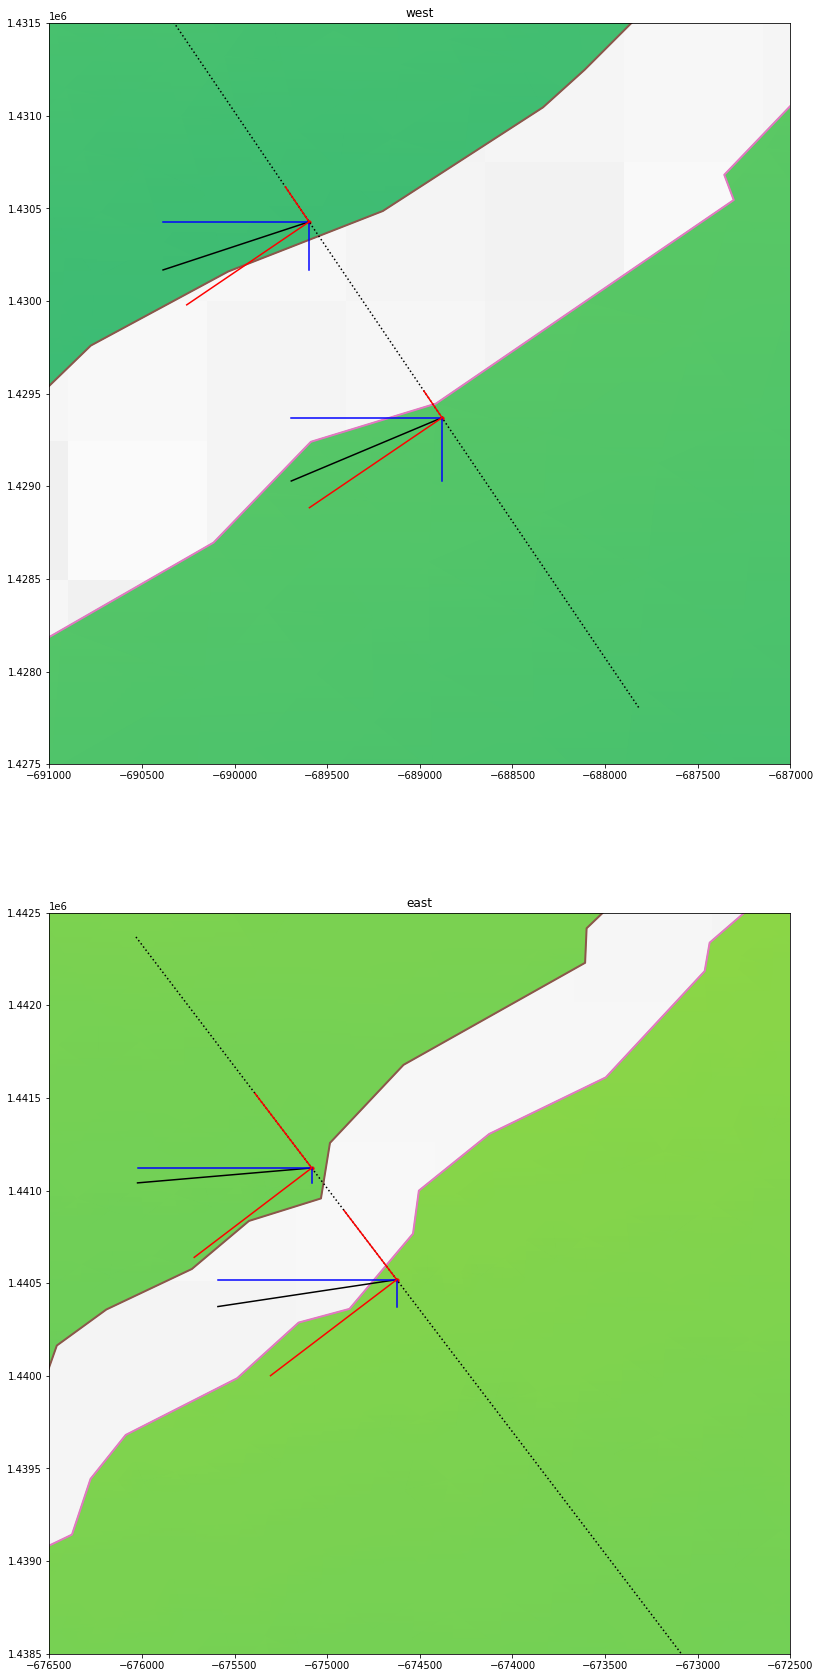

In [43]:
fig, axes = plt.subplots(2,1, figsize=(15,30))

axes[0].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=axes[0])

axes[1].imshow(image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent)
colors = icepack.plot.tripcolor(u_2021, vmin=0, vmax=1200, axes=axes[1])

for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[0].plot(xs[:, 0], xs[:, 1], linewidth=2)
        
for feature in outline_2021["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes[1].plot(xs[:, 0], xs[:, 1], linewidth=2)
        
axes[0].plot([easting_w_n,easting_w_s],[northing_w_n,northing_w_s],'k:')
axes[1].plot([easting_e_n,easting_e_s],[northing_e_n,northing_e_s],'k:')        
        
axes[0].scatter(w_n_x_calv,w_n_y_calv,s=10,c='r')
axes[0].scatter(w_s_x_calv,w_s_y_calv,s=10,c='r')
axes[1].scatter(e_n_x_calv,e_n_y_calv,s=10,c='r')
axes[1].scatter(e_s_x_calv,e_s_y_calv,s=10,c='r')

#model
vw_n_calv = u_2021((w_n_x_calv,w_n_y_calv))
vw_s_calv = u_2021((w_s_x_calv,w_s_y_calv))
ve_n_calv = u_2021((e_n_x_calv,e_n_y_calv))
ve_s_calv = u_2021((e_s_x_calv,e_s_y_calv))

#ft
ft_vw_n_calv = u0_2021((w_n_x_calv,w_n_y_calv))
ft_vw_s_calv = u0_2021((w_s_x_calv,w_s_y_calv))
ft_ve_n_calv = u0_2021((e_n_x_calv,e_n_y_calv))
ft_ve_s_calv = u0_2021((e_s_x_calv,e_s_y_calv))

#model
vw_n_calv_tot = np.sqrt((vw_n_calv[0]**2)+(vw_n_calv[1]**2))
vw_s_calv_tot = np.sqrt((vw_s_calv[0]**2)+(vw_s_calv[1]**2))
ve_n_calv_tot = np.sqrt((ve_n_calv[0]**2)+(ve_n_calv[1]**2))
ve_s_calv_tot = np.sqrt((ve_s_calv[0]**2)+(ve_s_calv[1]**2))

#ft
ft_vw_n_calv_tot = np.sqrt((ft_vw_n_calv[0]**2)+(ft_vw_n_calv[1]**2))
ft_vw_s_calv_tot = np.sqrt((ft_vw_s_calv[0]**2)+(ft_vw_s_calv[1]**2))
ft_ve_n_calv_tot = np.sqrt((ft_ve_n_calv[0]**2)+(ft_ve_n_calv[1]**2))
ft_ve_s_calv_tot = np.sqrt((ft_ve_s_calv[0]**2)+(ft_ve_s_calv[1]**2))

#axes.arrow(w_n_x_2021,w_n_y_2021,vw_n_2021[0],vw_n_2021[1],head_width=150,color='k')
#axes.arrow(w_s_x_2021,w_s_y_2021,vw_s_2021[0],vw_s_2021[1],head_width=150,color='k')
#axes.arrow(e_n_x_2021,e_n_y_2021,ve_n_2021[0],ve_n_2021[1],head_width=150,color='k')
#axes.arrow(e_s_x_2021,e_s_y_2021,ve_s_2021[0],ve_s_2021[1],head_width=150,color='k')

axes[0].plot([w_n_x_calv,w_n_x_calv+vw_n_calv[0]],[w_n_y_calv,w_n_y_calv+vw_n_calv[1]],color='k')
axes[0].plot([w_s_x_calv,w_s_x_calv+vw_s_calv[0]],[w_s_y_calv,w_s_y_calv+vw_s_calv[1]],color='k')
axes[1].plot([e_n_x_calv,e_n_x_calv+ve_n_calv[0]],[e_n_y_calv,e_n_y_calv+ve_n_calv[1]],color='k')
axes[1].plot([e_s_x_calv,e_s_x_calv+ve_s_calv[0]],[e_s_y_calv,e_s_y_calv+ve_s_calv[1]],color='k')

axes[0].plot([w_n_x_calv,w_n_x_calv+0],[w_n_y_calv,w_n_y_calv+vw_n_calv[1]],color='b')
axes[0].plot([w_s_x_calv,w_s_x_calv+0],[w_s_y_calv,w_s_y_calv+vw_s_calv[1]],color='b')
axes[1].plot([e_n_x_calv,e_n_x_calv+0],[e_n_y_calv,e_n_y_calv+ve_n_calv[1]],color='b')
axes[1].plot([e_s_x_calv,e_s_x_calv+0],[e_s_y_calv,e_s_y_calv+ve_s_calv[1]],color='b')

axes[0].plot([w_n_x_calv,w_n_x_calv+vw_n_calv[0]],[w_n_y_calv,w_n_y_calv+0],color='b')
axes[0].plot([w_s_x_calv,w_s_x_calv+vw_s_calv[0]],[w_s_y_calv,w_s_y_calv+0],color='b')
axes[1].plot([e_n_x_calv,e_n_x_calv+ve_n_calv[0]],[e_n_y_calv,e_n_y_calv+0],color='b')
axes[1].plot([e_s_x_calv,e_s_x_calv+ve_s_calv[0]],[e_s_y_calv,e_s_y_calv+0],color='b')

#model
vw_n_calv_angle = (math.atan(vw_n_calv[1]/vw_n_calv[0]))
vw_s_calv_angle = (math.atan(vw_s_calv[1]/vw_s_calv[0]))
ve_n_calv_angle = (math.atan(ve_n_calv[1]/ve_n_calv[0]))
ve_s_calv_angle = (math.atan(ve_s_calv[1]/ve_s_calv[0]))

#ft
ft_vw_n_calv_angle = (math.atan(ft_vw_n_calv[1]/ft_vw_n_calv[0]))
ft_vw_s_calv_angle = (math.atan(ft_vw_s_calv[1]/ft_vw_s_calv[0]))
ft_ve_n_calv_angle = (math.atan(ft_ve_n_calv[1]/ft_ve_n_calv[0]))
ft_ve_s_calv_angle = (math.atan(ft_ve_s_calv[1]/ft_ve_s_calv[0]))

print('-----------')
print(math.degrees(vw_n_calv_angle))
print(math.degrees(vw_s_calv_angle))
print(math.degrees(ve_n_calv_angle))
print(math.degrees(ve_s_calv_angle))
print('-----------')

#model
vw_n_calv_offset = abs(-90-math.degrees(vw_n_calv_angle) - math.degrees(west_angle))
vw_s_calv_offset = abs(-90-math.degrees(vw_s_calv_angle) - math.degrees(west_angle))
ve_n_calv_offset = abs(-90-math.degrees(ve_n_calv_angle) - math.degrees(east_angle))
ve_s_calv_offset = abs(-90-math.degrees(ve_s_calv_angle) - math.degrees(east_angle))

#ft
ft_vw_n_calv_offset = abs(-90-math.degrees(ft_vw_n_calv_angle) - math.degrees(west_angle))
ft_vw_s_calv_offset = abs(-90-math.degrees(ft_vw_s_calv_angle) - math.degrees(west_angle))
ft_ve_n_calv_offset = abs(-90-math.degrees(ft_ve_n_calv_angle) - math.degrees(east_angle))
ft_ve_s_calv_offset = abs(-90-math.degrees(ft_ve_s_calv_angle) - math.degrees(east_angle))

print("Ground track angles")
print("western pair: "+str(round(math.degrees(west_angle),1))+" deg")
print("western pair: "+str(round(west_angle,2))+" rad")
print("eastern pair: "+str(round(math.degrees(east_angle),1))+" deg")
print("western pair: "+str(round(east_angle,2))+" rad")
print("")
print("western pair, seaward")
print("v east: "+str(round(vw_n_calv[0],1))+"m/yr, v_north: "+str(round(vw_n_calv[1],1))+" m/yr, v_total: "+str(round(vw_n_calv_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(vw_n_calv_angle),1))+" deg")
print("offset: "+str(round(vw_n_calv_offset,1))+" deg")
print("")
print("western pair, landward")
print("v east: "+str(round(vw_s_calv[0],1))+"m/yr, v_north: "+str(round(vw_s_calv[1],1))+" m/yr, v_total: "+str(round(vw_s_calv_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(vw_s_calv_angle),1))+" deg")
print("offset: "+str(round(vw_s_calv_offset,1))+" deg")
print("")
print("eastern pair, seaward")
print("v east: "+str(round(ve_n_calv[0],1))+"m/yr, v_north: "+str(round(ve_n_calv[1],1))+" m/yr, v_total: "+str(round(ve_n_calv_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(ve_n_calv_angle),1))+" deg")
print("offset: "+str(round(ve_n_calv_offset,1))+" deg")
print("")
print("eastern pair, landward")
print("v east: "+str(round(ve_s_calv[0],1))+"m/yr, v_north: "+str(round(ve_s_calv[1],1))+" m/yr, v_total: "+str(round(ve_s_calv_tot,1))+" m/yr")
print("angle : "+str(round(-90-math.degrees(ve_s_calv_angle),1))+" deg")
print("offset: "+str(round(ve_s_calv_offset,1))+" deg")
print("")
print("------------------------------")
print("")
#calculate component of velocity in rift perpendicular direction
print("west,  seaward v_total: "+str(round(vw_n_calv_tot,1))+" m/yr")
print("west, landward v_total: "+str(round(vw_s_calv_tot,1))+" m/yr")
print("east,  seaward v_total: "+str(round(ve_n_calv_tot,1))+" m/yr")
print("east, landward v_total: "+str(round(ve_s_calv_tot,1))+" m/yr")
print("")

#model
vw_n_calv_perp = vw_n_calv_tot * math.cos(math.radians(vw_n_calv_offset))
vw_s_calv_perp = vw_s_calv_tot * math.cos(math.radians(vw_s_calv_offset))
ve_n_calv_perp = ve_n_calv_tot * math.cos(math.radians(ve_n_calv_offset))
ve_s_calv_perp = ve_s_calv_tot * math.cos(math.radians(ve_s_calv_offset))

vw_n_calv_para = vw_n_calv_tot * math.sin(math.radians(vw_n_calv_offset))
vw_s_calv_para = vw_s_calv_tot * math.sin(math.radians(vw_s_calv_offset))
ve_n_calv_para = ve_n_calv_tot * math.sin(math.radians(ve_n_calv_offset))
ve_s_calv_para = ve_s_calv_tot * math.sin(math.radians(ve_s_calv_offset))

#ft
ft_vw_n_calv_perp = ft_vw_n_calv_tot * math.cos(math.radians(ft_vw_n_calv_offset))
ft_vw_s_calv_perp = ft_vw_s_calv_tot * math.cos(math.radians(ft_vw_s_calv_offset))
ft_ve_n_calv_perp = ft_ve_n_calv_tot * math.cos(math.radians(ft_ve_n_calv_offset))
ft_ve_s_calv_perp = ft_ve_s_calv_tot * math.cos(math.radians(ft_ve_s_calv_offset))

ft_vw_n_calv_para = ft_vw_n_calv_tot * math.cos(math.radians(ft_vw_n_calv_offset))
ft_vw_s_calv_para = ft_vw_s_calv_tot * math.cos(math.radians(ft_vw_s_calv_offset))
ft_ve_n_calv_para = ft_ve_n_calv_tot * math.cos(math.radians(ft_ve_n_calv_offset))
ft_ve_s_calv_para = ft_ve_s_calv_tot * math.cos(math.radians(ft_ve_s_calv_offset))

print("west,   seaward v_perp: "+str(round(vw_n_calv_perp,1))+" m/yr")
print("west,  landward v_perp: "+str(round(vw_s_calv_perp,1))+" m/yr")
print("east,   seaward v_perp: "+str(round(ve_n_calv_perp,1))+" m/yr")
print("east,  landward v_perp: "+str(round(ve_s_calv_perp,1))+" m/yr")
print("")
print("west,   seaward v_para: "+str(round(vw_n_calv_para,1))+" m/yr")
print("west,  landward v_para: "+str(round(vw_s_calv_para,1))+" m/yr")
print("east,   seaward v_para: "+str(round(ve_n_calv_para,1))+" m/yr")
print("east,  landward v_para: "+str(round(ve_s_calv_para,1))+" m/yr")
print("")

#velocity components sanity check
vw_n_calv_check = np.sqrt((vw_n_calv_perp**2)+(vw_n_calv_para**2))
vw_s_calv_check = np.sqrt((vw_s_calv_perp**2)+(vw_s_calv_para**2))
ve_n_calv_check = np.sqrt((ve_n_calv_perp**2)+(ve_n_calv_para**2))
ve_s_calv_check = np.sqrt((ve_s_calv_perp**2)+(ve_s_calv_para**2))

print("west,  seaward v_check: "+str(round(vw_n_calv_check,1))+" m/yr (difference: "+str(round(vw_n_calv_tot-vw_n_calv_check,1))+"m/yr)")
print("west, landward v_check: "+str(round(vw_s_calv_check,1))+" m/yr (difference: "+str(round(vw_s_calv_tot-vw_s_calv_check,1))+"m/yr)")
print("east,  seaward v_check: "+str(round(ve_n_calv_check,1))+" m/yr (difference: "+str(round(ve_n_calv_tot-ve_n_calv_check,1))+"m/yr)")
print("east, landward v_check: "+str(round(ve_s_calv_check,1))+" m/yr (difference: "+str(round(ve_s_calv_tot-ve_s_calv_check,1))+"m/yr)")
print("")

axes[0].plot([w_n_x_calv,w_n_x_calv+(vw_n_calv_perp*math.sin(west_angle))],[w_n_y_calv,w_n_y_calv+(vw_n_calv_perp*math.cos(west_angle))],color='r')
axes[0].plot([w_s_x_calv,w_s_x_calv+(vw_s_calv_perp*math.sin(west_angle))],[w_s_y_calv,w_s_y_calv+(vw_s_calv_perp*math.cos(west_angle))],color='r')
axes[1].plot([e_n_x_calv,e_n_x_calv+(ve_n_calv_perp*math.sin(east_angle))],[e_n_y_calv,e_n_y_calv+(ve_n_calv_perp*math.cos(east_angle))],color='r')
axes[1].plot([e_s_x_calv,e_s_x_calv+(ve_s_calv_perp*math.sin(east_angle))],[e_s_y_calv,e_s_y_calv+(ve_s_calv_perp*math.cos(east_angle))],color='r')

axes[0].plot([w_n_x_calv,w_n_x_calv-(vw_n_calv_para*math.cos(west_angle))],[w_n_y_calv,w_n_y_calv+(vw_n_calv_para*math.sin(west_angle))],color='r')
axes[0].plot([w_s_x_calv,w_s_x_calv-(vw_s_calv_para*math.cos(west_angle))],[w_s_y_calv,w_s_y_calv+(vw_s_calv_para*math.sin(west_angle))],color='r')
axes[1].plot([e_n_x_calv,e_n_x_calv-(ve_n_calv_para*math.cos(east_angle))],[e_n_y_calv,e_n_y_calv+(ve_n_calv_para*math.sin(east_angle))],color='r')
axes[1].plot([e_s_x_calv,e_s_x_calv-(ve_s_calv_para*math.cos(east_angle))],[e_s_y_calv,e_s_y_calv+(ve_s_calv_para*math.sin(east_angle))],color='r')



#difference across rift
#model open
vdiffw_calv = vw_n_calv_perp - vw_s_calv_perp
vdiffe_calv = ve_n_calv_perp - ve_s_calv_perp
#model shear
vshearw_calv = vw_n_calv_para - vw_s_calv_para
vsheare_calv = ve_n_calv_para - ve_s_calv_para

#ft
ft_vdiffw_calv = ft_vw_n_calv_perp - ft_vw_s_calv_perp
ft_vdiffe_calv = ft_ve_n_calv_perp - ft_ve_s_calv_perp

print("Western opening rate: "+str(round(vdiffw_calv,1))+" m/yr")
print("Eastern opening rate: "+str(round(vdiffe_calv,1))+" m/yr")
print("")
print("Western shear rate: "+str(round(vshearw_calv,1))+" m/yr")
print("Eastern shear rate: "+str(round(vsheare_calv,1))+" m/yr")

print("")
print("")
print("")
print("blue  - x and y in projection")
print("black - velocity vector")
print("red   - rift perpendicular and parallel velocity components")

axes[0].set_title("west")
axes[0].set_xlim(xcen_w-delta,xcen_w+delta)
axes[0].set_ylim(ycen_w-delta,ycen_w+delta)

axes[1].set_title("east")
axes[1].set_xlim(xcen_e-delta,xcen_e+delta)
axes[1].set_ylim(ycen_e-delta,ycen_e+delta)

plt.show()

In [44]:
print("------------------------------")
print("Geometry: calving")
print("Rift:     calving")
print("Model:    Near-calving rift opening rate")
print("Temp:     Inverse")
print("")
print("Opening rates: feature tracking")
print("Western:  "+str(round(ft_vdiffw_calv,1))+" m/yr")
print("Eastern:  "+str(round(ft_vdiffe_calv,1))+" m/yr")
print("")
print("Opening rates: model")
print("Western:  "+str(round(vdiffw_calv,1))+" m/yr")
print("Eastern:  "+str(round(vdiffe_calv,1))+" m/yr")

------------------------------
Geometry: calving
Rift:     calving
Model:    Near-calving rift opening rate
Temp:     Inverse

Opening rates: feature tracking
Western:  -2.3 m/yr
Eastern:  4.7 m/yr

Opening rates: model
Western:  53.6 m/yr
Eastern:  36.4 m/yr


In [45]:
inverse_results_calv = {
    "vw_n_calv_x": vw_n_calv[0],
    "vw_n_calv_y": vw_n_calv[1],
    "vw_s_calv_x": vw_s_calv[0],
    "vw_s_calv_y": vw_s_calv[1],
    "vw_n_calv_x_rperp": vw_n_calv_perp*math.sin(west_angle),
    "vw_n_calv_y_rperp": vw_n_calv_perp*math.cos(west_angle),
    "vw_s_calv_x_rperp": vw_s_calv_perp*math.sin(west_angle),
    "vw_s_calv_y_rperp": vw_s_calv_perp*math.cos(west_angle),
    "ve_n_calv_x": ve_n_calv[0],
    "ve_n_calv_y": ve_n_calv[1],
    "ve_s_calv_x": ve_s_calv[0],
    "ve_s_calv_y": ve_s_calv[1],
    "ve_n_calv_x_rperp": ve_n_calv_perp*math.sin(east_angle),
    "ve_n_calv_y_rperp": ve_n_calv_perp*math.cos(east_angle),
    "ve_s_calv_x_rperp": ve_s_calv_perp*math.sin(east_angle),
    "ve_s_calv_y_rperp": ve_s_calv_perp*math.cos(east_angle)
}

outp1 = open("./output/inverse_results_calve.pkl", "wb")

pickle.dump(inverse_results_calv,outp1)

outp1.close()

